## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-07-31 14:21:08.810 | INFO     |  Running on cuda:0


In [3]:
task = 'StackWine'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-07-31 14:21:10.582 | INFO     |  Loading dataset(s): 
2024-07-31 14:21:10.583 | INFO     |    Initializing datasete using /home/hartzj/VinDihsl/MT-GMM/data/StackWine/demos/metadata.json
2024-07-31 14:21:10.583 | INFO     |    Extracted gt object labels [82, 88]
2024-07-31 14:21:10.583 | INFO     |    Extracted tsdf object labels []
2024-07-31 14:21:10.584 | INFO     |    Done! Data contains 5 trajectories.


In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'base',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)

n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)

2024-07-31 14:21:13.396 | INFO     |  Subsampling to length 178 using strategy mean-length.


In [6]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    add_gripper_action=True,

    reg_shrink=1e-2,
    reg_diag=1e-3,
    reg_diag_gripper=1e-1,

    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=1e-3,
    reg_em_finish_diag_gripper=1e-1,

    fix_first_component=True,
    fix_last_component=True,
    
    fixed_last_component_n_steps=2,

    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,

    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,
    repeat_first_step=0,

    components_prop_to_len=True,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=False,
    kl_keep_rotation_dim=False,
    kl_sigma_scale=1.0,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)


In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2024-07-31 14:21:13.508 | INFO     |  Fitting AutoTPGMM
2024-07-31 14:21:13.508 | INFO     |  Performing fitting actions: [INIT]
2024-07-31 14:21:13.508 | INFO     |  Segmenting trajectories


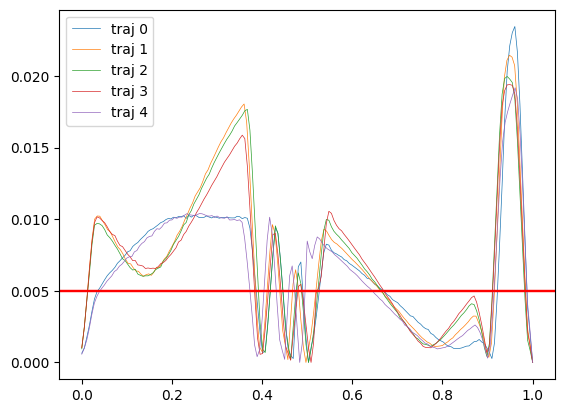

2024-07-31 14:21:13.626 | INFO     |  Creating segement of demos.
2024-07-31 14:21:13.628 | INFO     |  Subsampling to length 70 using strategy mean-length.
2024-07-31 14:21:13.628 | INFO     |  Creating segement of demos.
2024-07-31 14:21:13.629 | INFO     |  Subsampling to length 14 using strategy mean-length.
2024-07-31 14:21:13.629 | INFO     |  Creating segement of demos.
2024-07-31 14:21:13.630 | INFO     |  Subsampling to length 55 using strategy mean-length.
2024-07-31 14:21:13.631 | INFO     |  Creating segement of demos.
2024-07-31 14:21:13.632 | INFO     |  Subsampling to length 38 using strategy mean-length.
2024-07-31 14:21:13.632 | INFO     |  ... created 4 segments
2024-07-31 14:21:13.632 | INFO     |    Fitting candidate frame 1/3
2024-07-31 14:21:13.632 | INFO     |    Creating partial frame view of demos.
2024-07-31 14:21:13.635 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2024-07-31 14:21:13.635 | INFO     |    Changing number of components to 7
2024-07-31 14:21:1

Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-07-31 14:21:13.799 | INFO     |    Fitting candidate frame 2/3
2024-07-31 14:21:13.799 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-07-31 14:21:14.010 | INFO     |    Fitting candidate frame 3/3
2024-07-31 14:21:14.010 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-07-31 14:21:14.232 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-07-31 14:21:14.232 | INFO     |  obj000     score (rel):     -1 (0.500)
2024-07-31 14:21:14.232 | INFO     |  obj001     score (rel):     -0 (0.500)
2024-07-31 14:21:14.232 | INFO     |  Creating partial frame view of demos.
2024-07-31 14:21:14.234 | INFO     |    Fitting candidate frame 1/3
2024-07-31 14:21:14.234 | INFO     |    Creating partial frame view of demos.
2024-07-31 14:21:14.238 | INFO     |    Changing number of components to 1


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2024-07-31 14:21:14.272 | INFO     |    Fitting candidate frame 2/3
2024-07-31 14:21:14.272 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2024-07-31 14:21:14.308 | INFO     |    Fitting candidate frame 3/3
2024-07-31 14:21:14.308 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2024-07-31 14:21:14.360 | INFO     |  ee_init    score (rel):     -0 (0.000)
2024-07-31 14:21:14.361 | INFO     |  obj000     score (rel):     -0 (1.000)
2024-07-31 14:21:14.361 | INFO     |  obj001     score (rel):     -0 (1.000)
2024-07-31 14:21:14.361 | INFO     |  Creating partial frame view of demos.
2024-07-31 14:21:14.362 | INFO     |    Fitting candidate frame 1/3
2024-07-31 14:21:14.362 | INFO     |    Creating partial frame view of demos.
2024-07-31 14:21:14.368 | INFO     |    Changing number of components to 6


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-07-31 14:21:14.521 | INFO     |    Fitting candidate frame 2/3
2024-07-31 14:21:14.521 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-07-31 14:21:14.697 | INFO     |    Fitting candidate frame 3/3
2024-07-31 14:21:14.697 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-07-31 14:21:14.869 | INFO     |  ee_init    score (rel):     -0 (0.098)
2024-07-31 14:21:14.870 | INFO     |  obj000     score (rel):     -1 (1.000)
2024-07-31 14:21:14.870 | INFO     |  obj001     score (rel):     -1 (1.000)
2024-07-31 14:21:14.870 | INFO     |  Creating partial frame view of demos.
2024-07-31 14:21:14.871 | INFO     |    Fitting candidate frame 1/3
2024-07-31 14:21:14.871 | INFO     |    Creating partial frame view of demos.
2024-07-31 14:21:14.875 | INFO     |    Changing number of components to 4


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-07-31 14:21:14.966 | INFO     |    Fitting candidate frame 2/3
2024-07-31 14:21:14.966 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-07-31 14:21:15.099 | INFO     |    Fitting candidate frame 3/3
2024-07-31 14:21:15.100 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-07-31 14:21:15.195 | INFO     |  ee_init    score (rel):     -0 (0.081)
2024-07-31 14:21:15.196 | INFO     |  Creating partial frame view of demos.
2024-07-31 14:21:15.197 | INFO     |  Segmented trajs into 4 segments
2024-07-31 14:21:15.200 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001
Segment 0 -0.999914 -0.500176 -0.499751
Segment 1 -0.000042 -0.499981 -0.499977
Segment 2 -0.048947 -0.500007 -0.500155
Segment 3 -0.040714 -0.499984 -0.500063
2024-07-31 14:21:15.201 | INFO     |  Frame score (rel):
            ee_init    obj000    obj001
Segment 0  1.000000  0.500219  0.499794
Segment 1  0.000084  1.000000  0.999991
Segment 2  0.097864  0.999704  1.000000
Segment 3  0.081417  0.999841  1.000000


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2024-07-31 14:21:15.223 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

((array([[6.55e+20, 6.57e+20, 3.20e+20, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.07e+17, 3.97e+17, 9.80e+17, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [8.76e+04, 4.98e+06, 1.55e+08, ..., 5.60e-90, 6.61e-92, 2.30e-92],
         ...,
         [7.32e-39, 9.06e-36, 4.33e-33, ..., 1.26e+02, 1.15e+01, 1.56e+00],
         [7.26e-97, 3.39e-94, 9.03e-92, ..., 5.22e+16, 2.24e+16, 9.15e+15],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.00e+20, 2.38e+20, 1.24e+20]]),
  array([[5.11e+23, 6.51e+23, 5.11e+23, 2.16e+23, 2.77e+22, 2.45e+20,
          2.96e+16, 5.37e+06, 8.25e+01, 2.41e-02, 0.00e+00, 0.00e+00,
          0.00e+00, 0.00e+00, 4.83e+23, 6.62e+23, 5.18e+23, 2.16e+23,
          2.35e+22, 1.52e+20, 1.11e+16, 3.41e+10, 6.86e+04, 9.33e-01,
          0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 5.18e+23, 6.61e+23,
          4.44e+23, 7.99e+22, 9.35e+20, 1.29e+17, 7.24e+11, 5.89e+10,
          1.19e+05, 1.33e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
          5.16e+23, 6.60e+23, 5.18e+23

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-07-31 14:21:16.199 | INFO     |  Did not specify time_based, deciding automatically.
2024-07-31 14:21:16.489 | WARNING  |  Skippig NaN Gaussians.


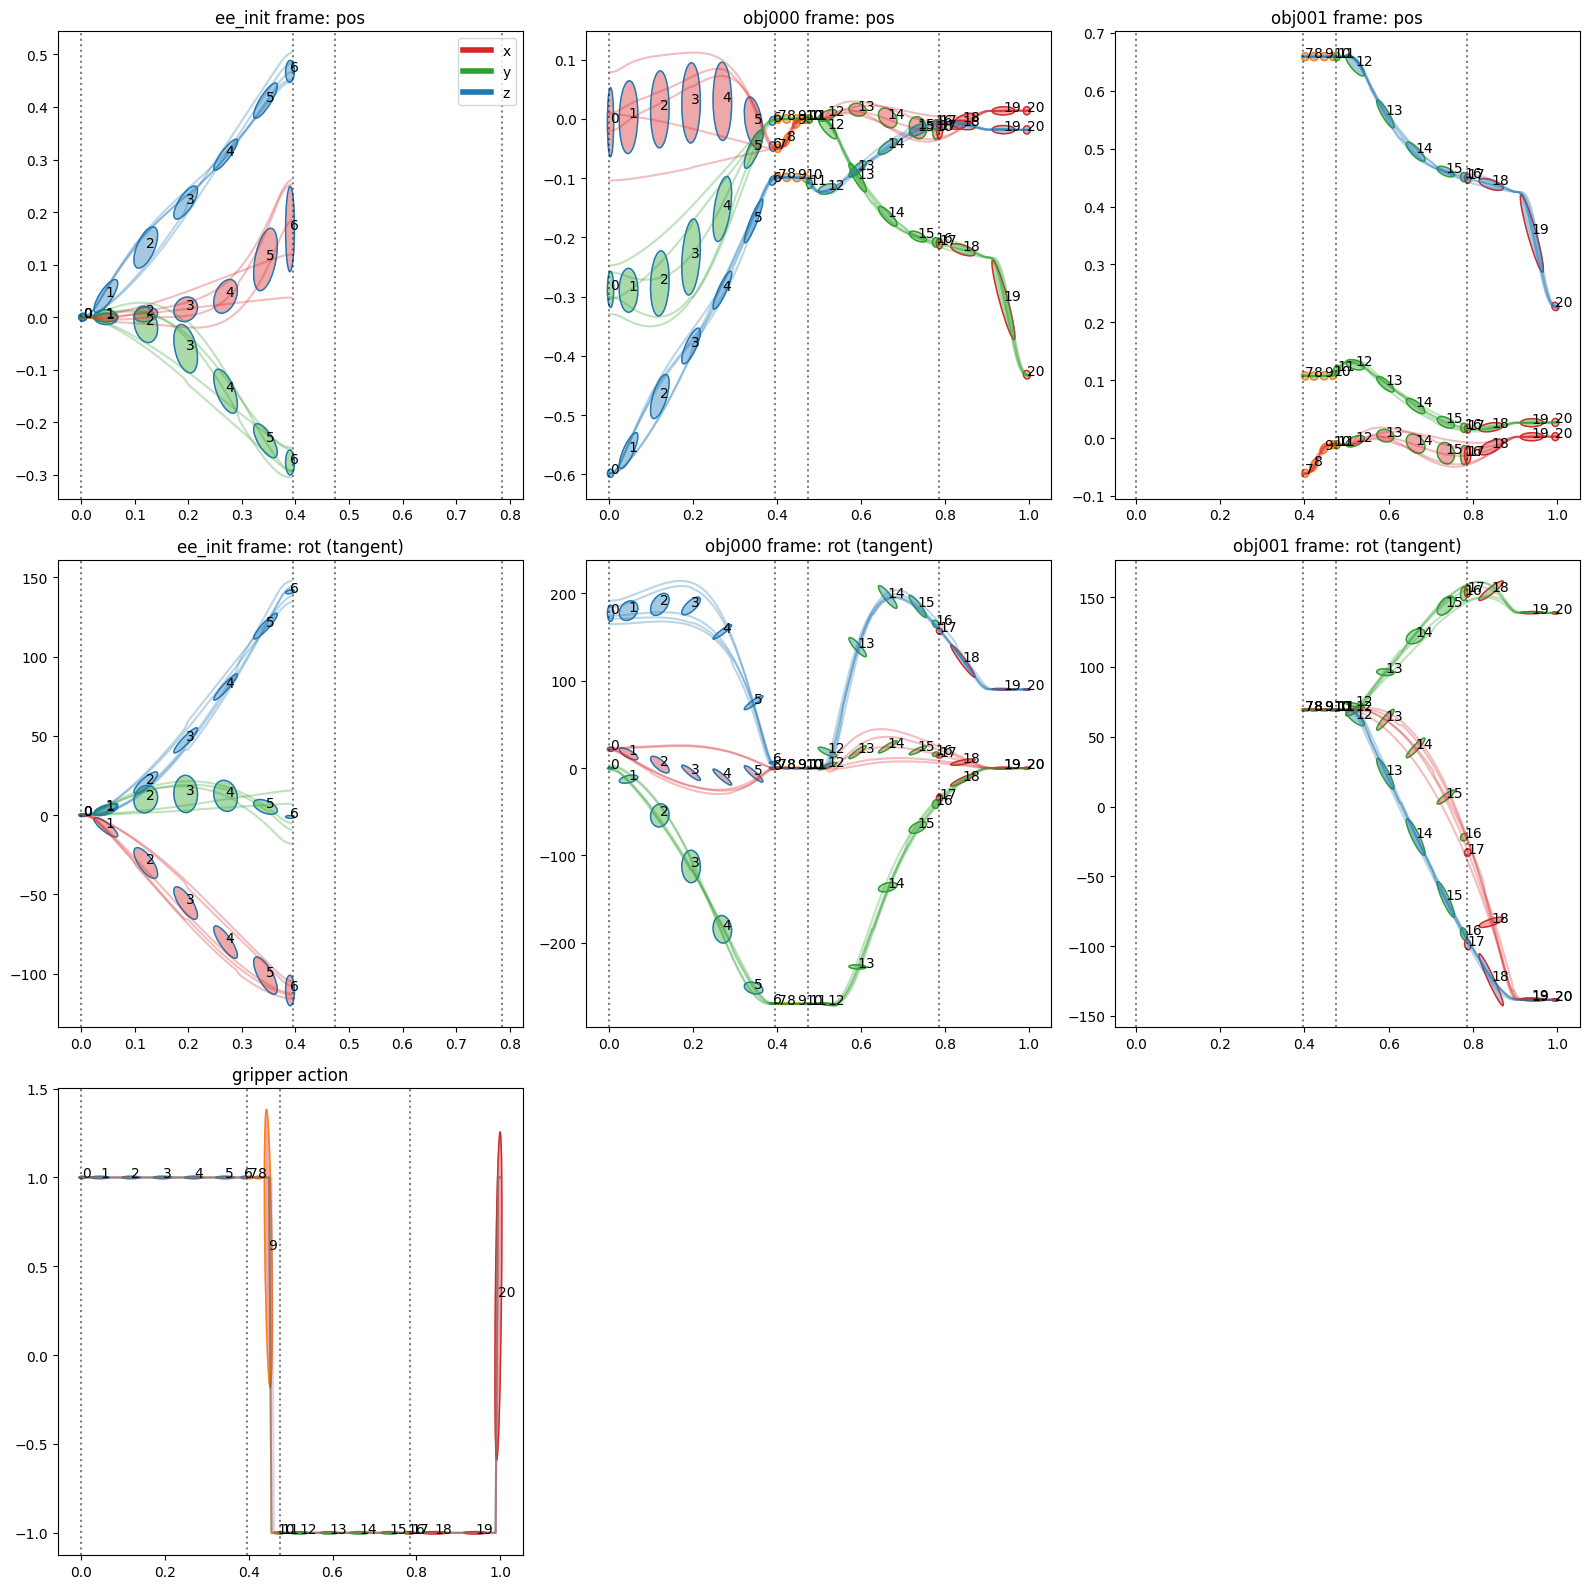

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2024-07-31 14:21:18.740 | INFO     |  Fitting AutoTPGMM
2024-07-31 14:21:18.740 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2024-07-31 14:21:18.745 | INFO     |  HMM EM ...
2024-07-31 14:21:18.749 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2024-07-31 14:21:18.797 | INFO     |  HMM init priors not defined, initializing to uniform
2024-07-31 14:21:37.578 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1., 1., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 1., 1., 1.]]),
  array([[1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  ,
          0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.99, 0.  ,
          0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
          1.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  ,
          1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
          0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.98, 0.6 , 0.  , 0.  ,
          0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.39, 0.  , 0.  ,
          0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 1.  ,
          0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
          0.  , 0.99, 0.5

2024-07-31 14:21:45.186 | INFO     |  Did not specify time_based, deciding automatically.


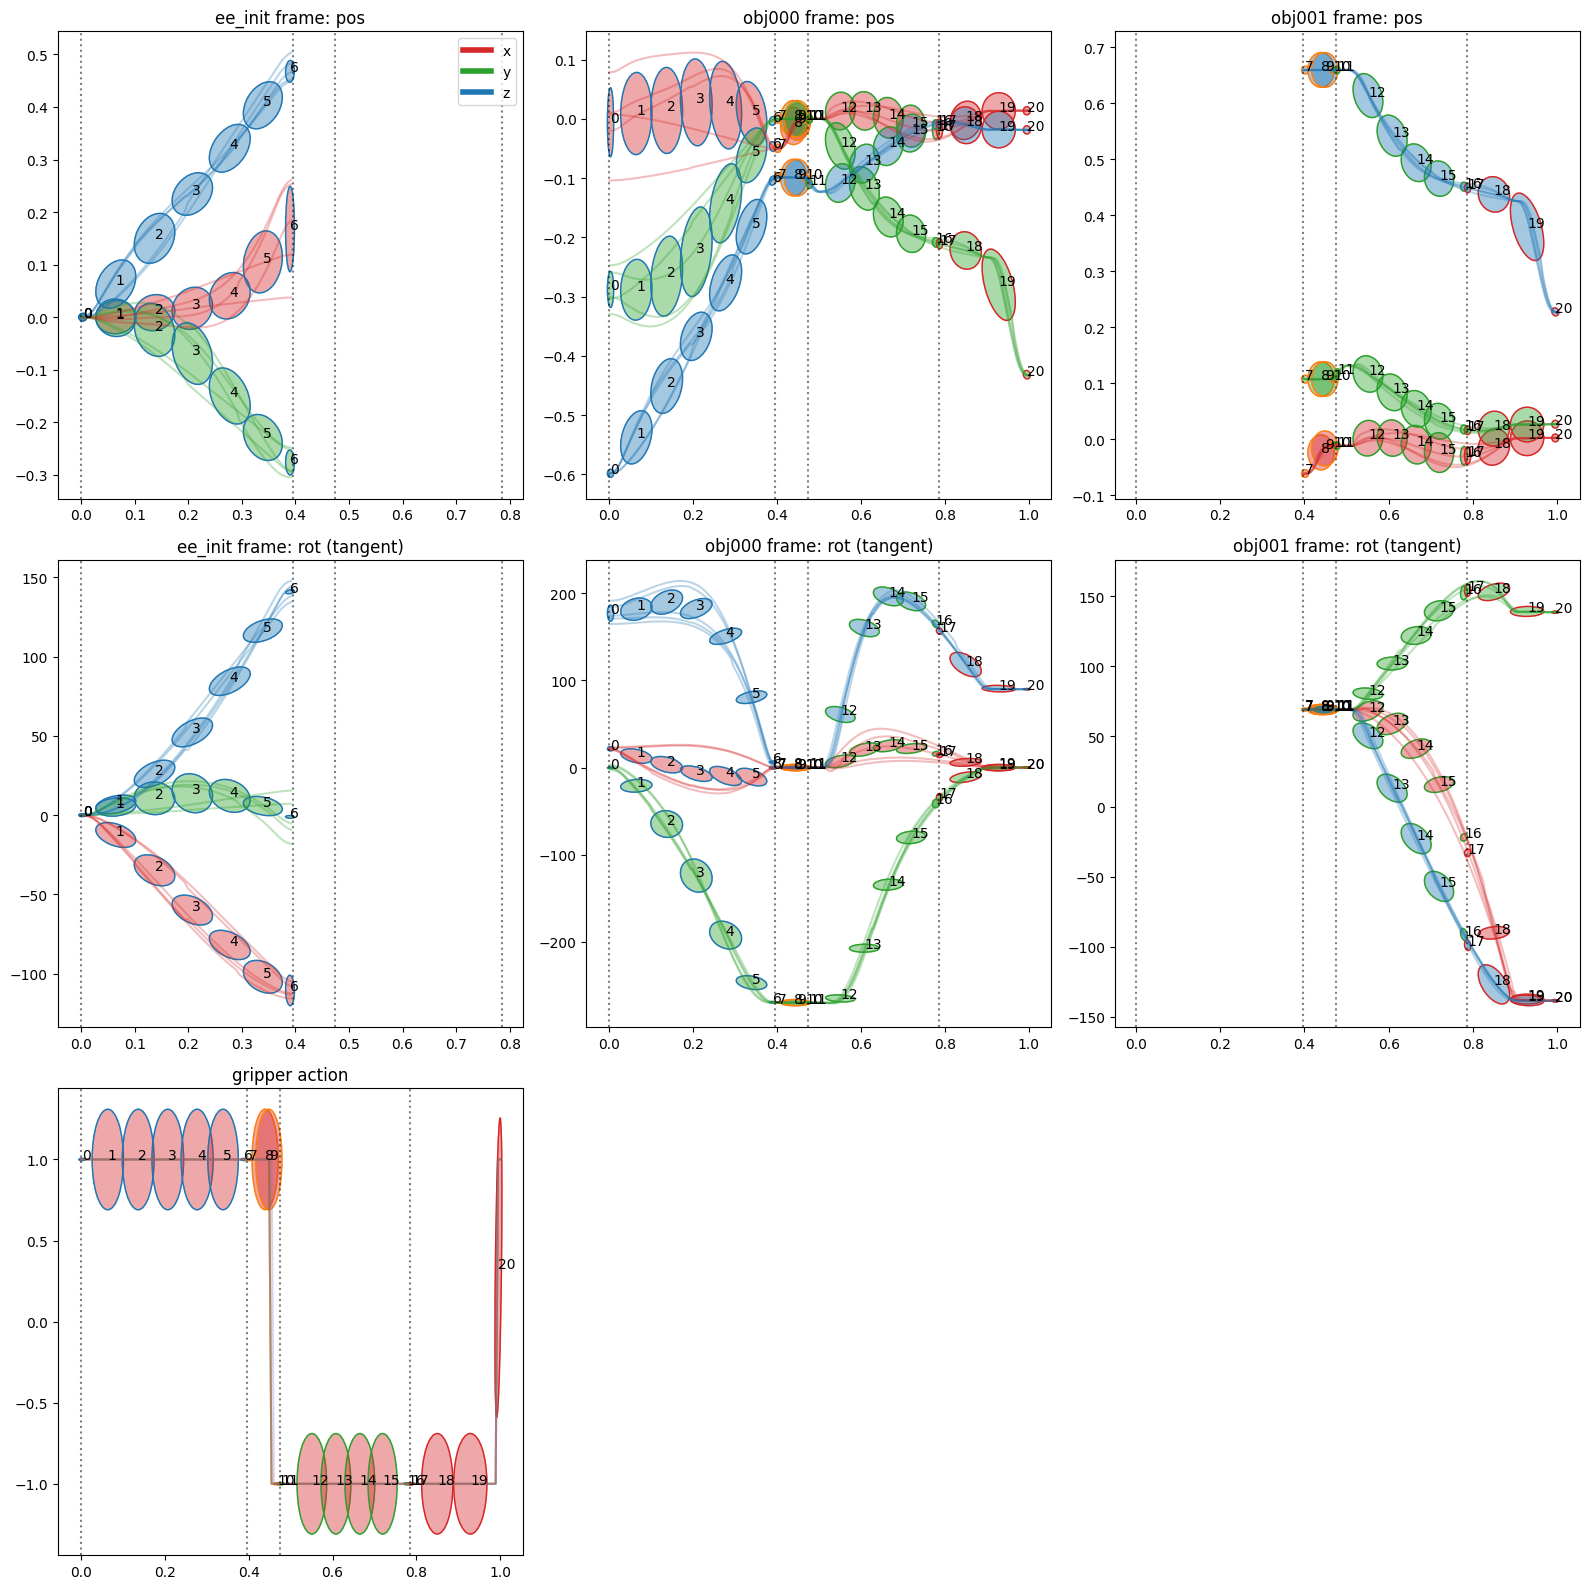

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

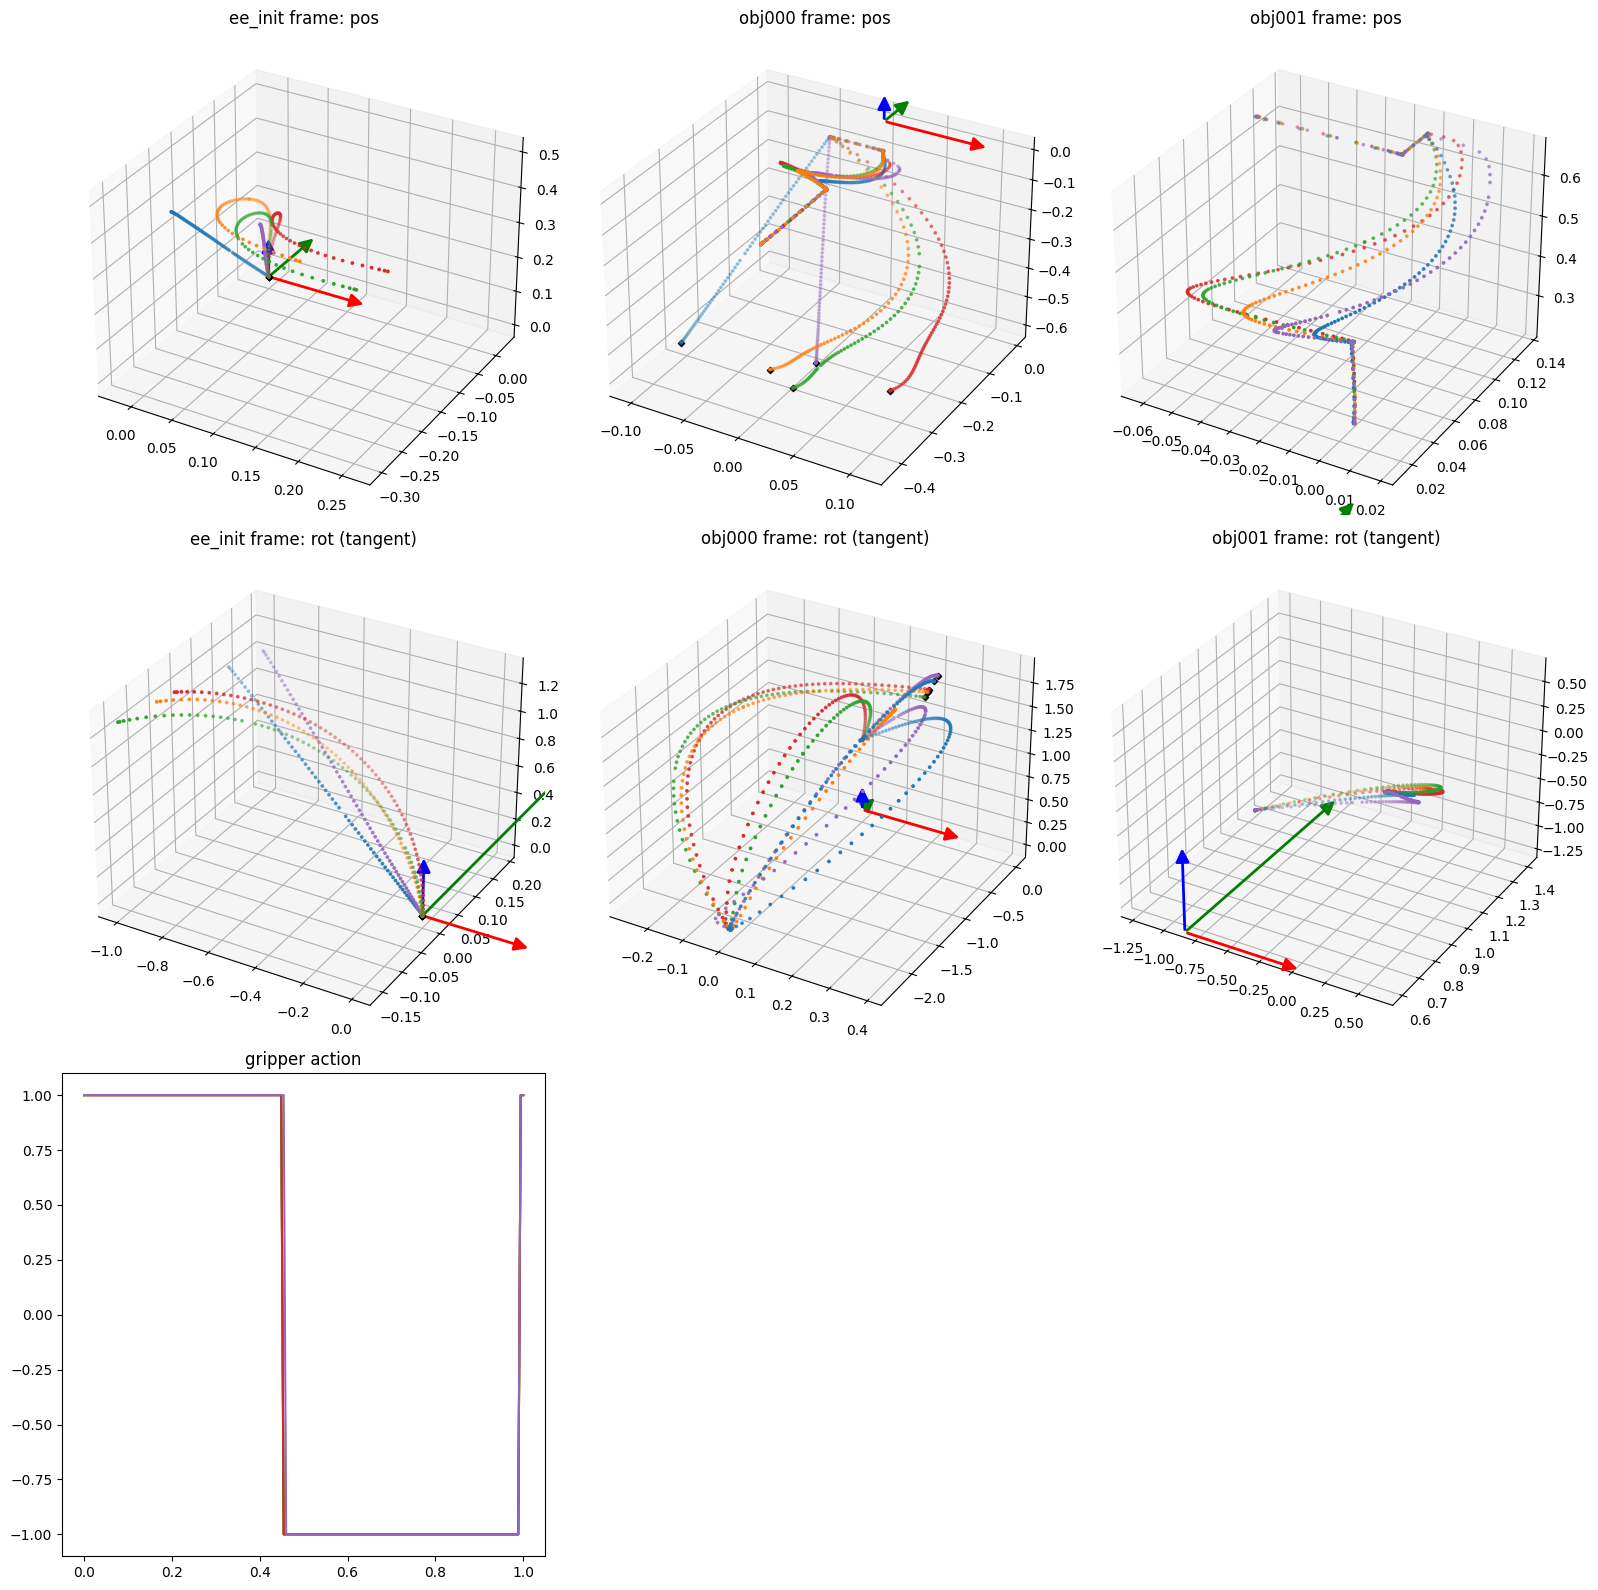

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

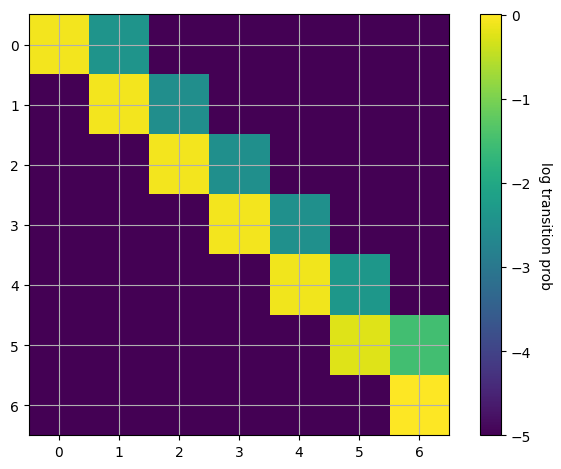

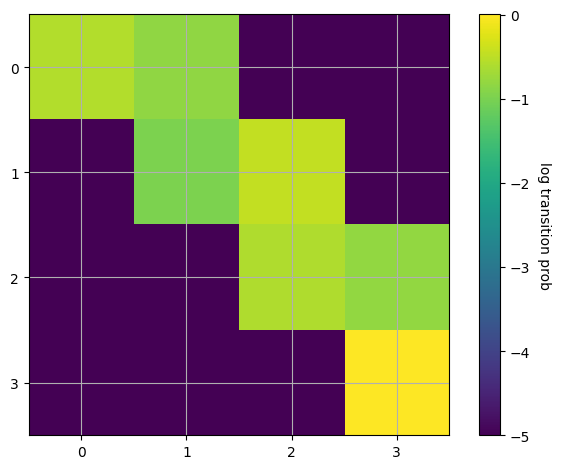

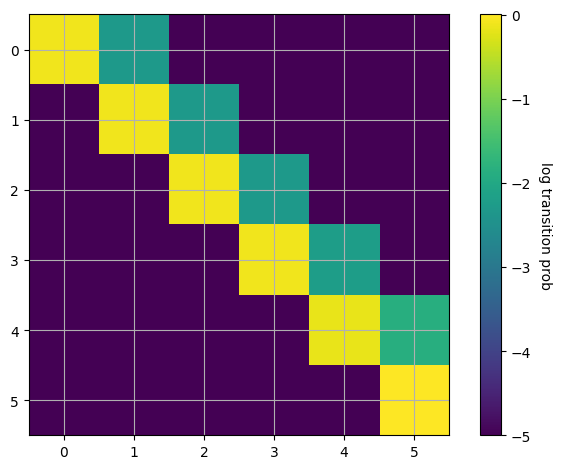

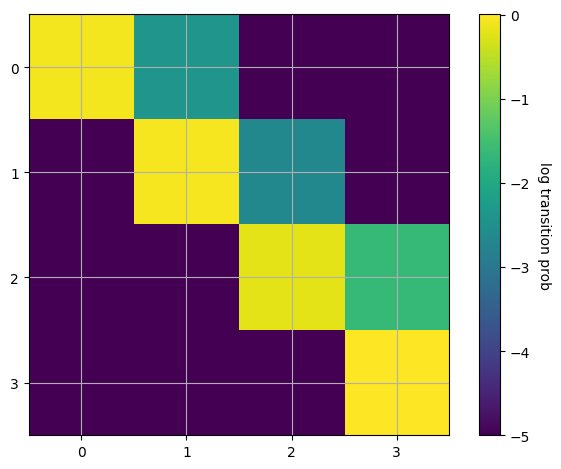

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-auto-time-velsplit-release.pt')

2024-07-31 14:21:49.174 | INFO     |  Saving model:


In [16]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-07-31 14:25:40.617 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-07-31 14:25:40.665 | INFO     |  Caculated segment transition probabilities: (array([[0.59]]), array([[0.51]]), array([[0.93]]))
2024-07-31 14:25:40.665 | INFO     |  Creating partial frame view of demos.
2024-07-31 14:25:40.744 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-07-31 14:25:40.825 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-07-31 14:25:40.866 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-07-31 14:25:40.915 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-07-31 14:25:40.951 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

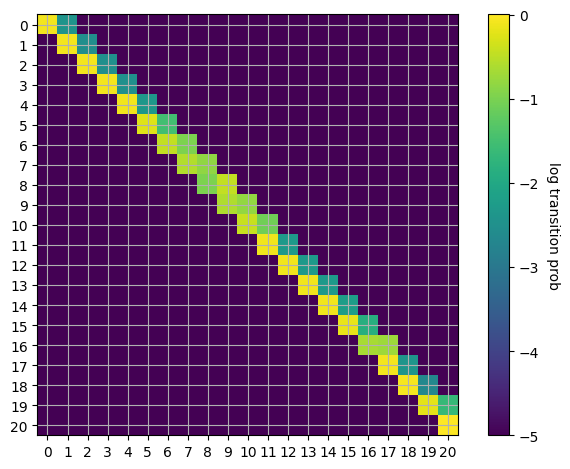

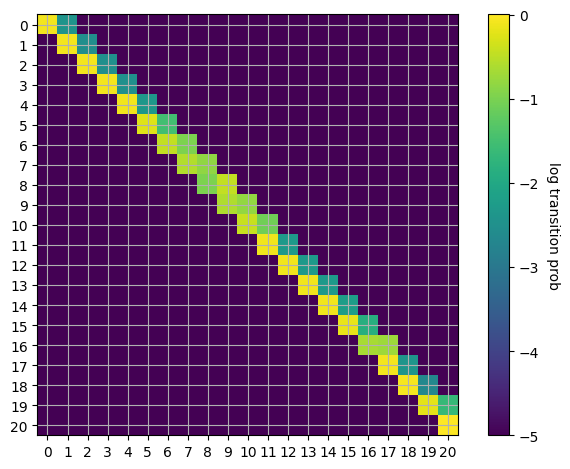

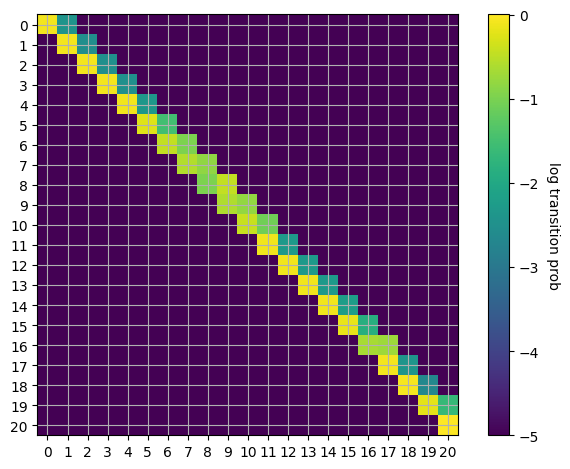

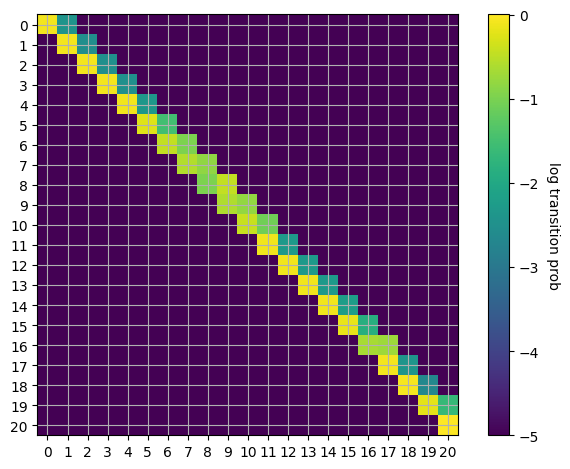

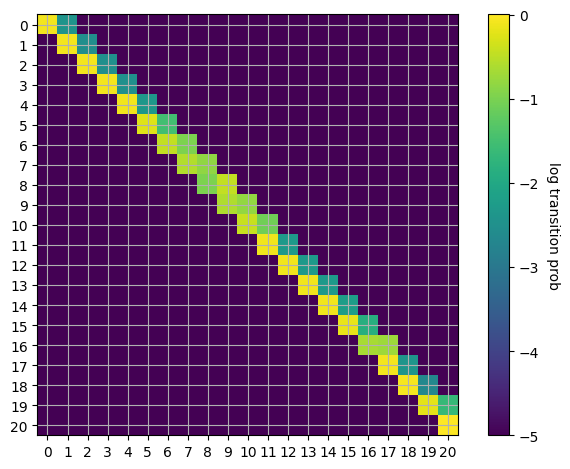

In [ ]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2024-07-31 14:27:59.360 | INFO     |  Taking frame origins from demos.


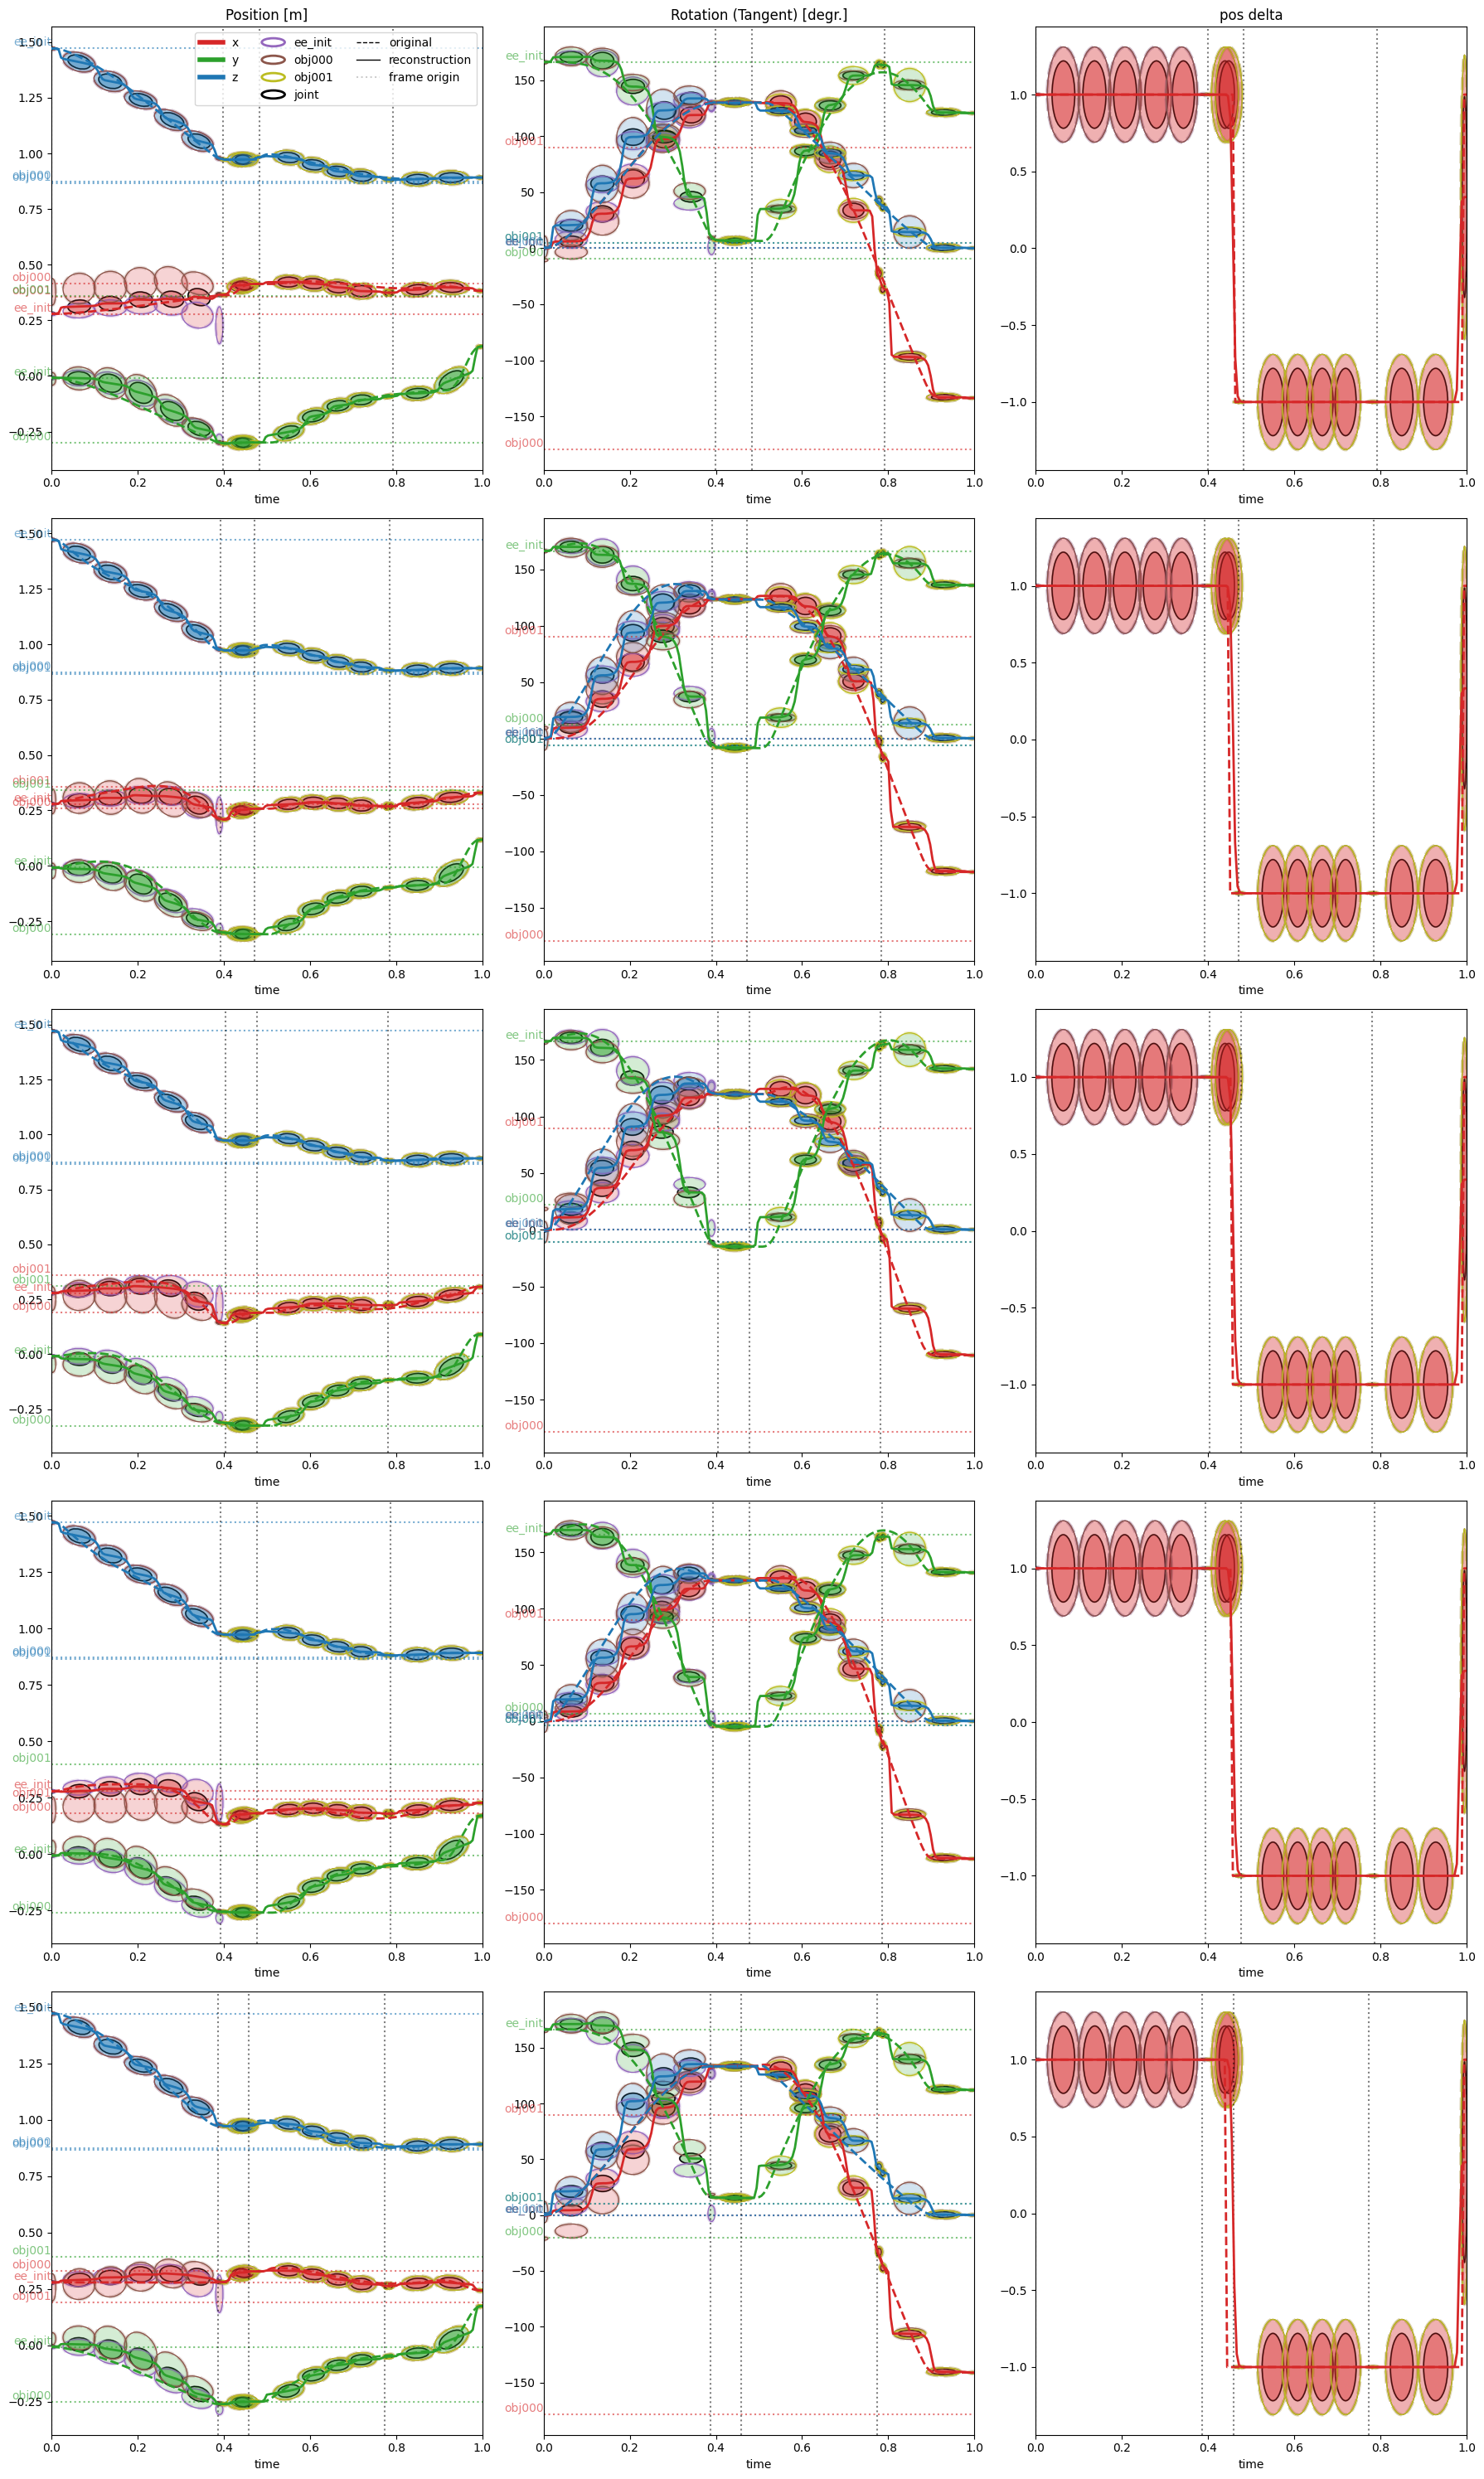

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


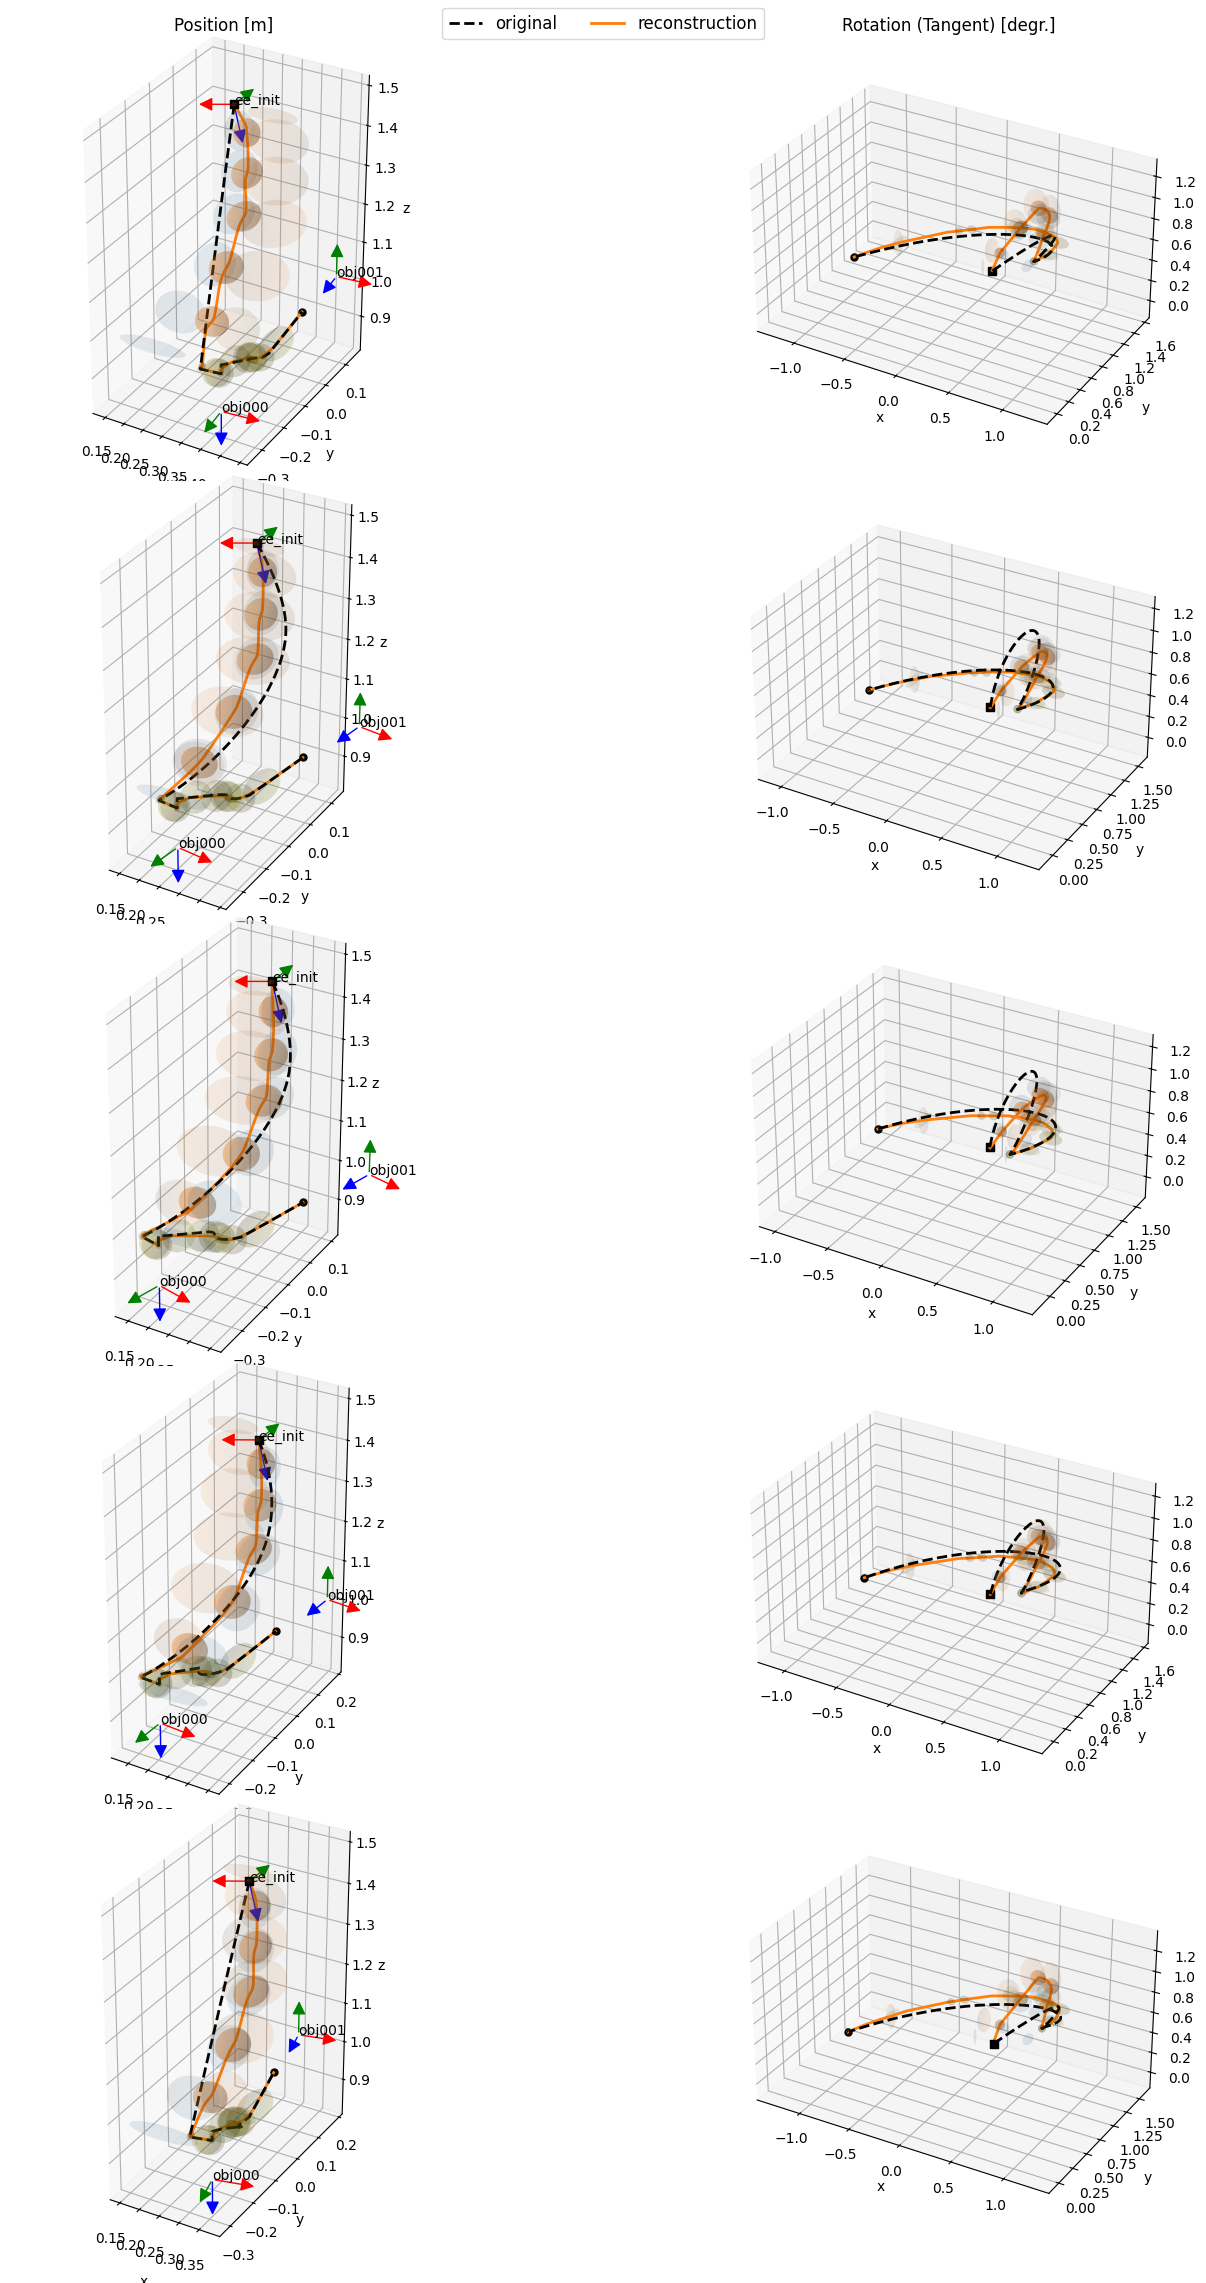

In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)
